<a href="https://colab.research.google.com/github/rankitagarwal/Walmart-store-sales-forecasting/blob/main/Walmart_StoreSalesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Walmart - Store Sales Forecasting

## 1. Buisness Problem

### 1.1 Description
historical sales data for 45 Walmart stores located in different regions. Each store contains many departments, and participants must project the sales for each department in each store. To add to the challenge, selected holiday markdown events are included in the dataset. These markdowns are known to affect sales, but it is challenging to predict which departments are affected and the extent of the impact.



### 1.2 Objective and Constraints
1. No latency constraint
2. Use WMAE which should be high and Holiday should give more weightage

## 2. Machine Learning Problem

### 2.1 Data Overview
stores.csv

This file contains anonymized information about the 45 stores, indicating the type and size of store.

train.csv

This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

Store - the store number
Dept - the department number
Date - the week
Weekly_Sales -  sales for the given department in the given store
IsHoliday - whether the week is a special holiday week
test.csv

This file is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.

features.csv

This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

Store - the store number
Date - the week
Temperature - average temperature in the region
Fuel_Price - cost of fuel in the region
MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
CPI - the consumer price index
Unemployment - the unemployment rate
IsHoliday - whether the week is a special holiday week
For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

### 2.2 Mapping Real world Problem
#### 2.2.1 Type of model
Regression problem with time series data
#### 2.2.2 Performance Metics
Source: https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/overview/evaluation

Merics: WMAE:weightage Mean Absolute Error
This competition is evaluated on the weighted mean absolute error (WMAE):
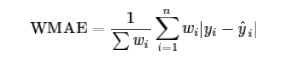

where

n is the number of rows
y^ is the predicted sales
y is the actual sales
w are weights. w = 5 if the week is a holiday week, 1 otherwise


## 3. Exploratory Data Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from datetime import datetime

Importing Data

In [ ]:
# !pip install kaggle --upgrade
os.environ['KAGGLE_USERNAME'] = 'rankit97'
os.environ['KAGGLE_KEY'] = 'e83c2ff5d4ae14d59e0d3723c806c9a8'
!kaggle -v
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting

Kaggle API 1.5.4
stores.csv: Skipping, found more recently modified local copy (use --force to force download)
sampleSubmission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
features.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip train.csv.zip
!unzip features.csv
!unzip test.csv.zip

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: train.csv               
Archive:  features.csv
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
Archive:  features.csv.zip
replace features.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
dataframe = pd.read_csv("train.csv")
test_dataframe = pd.read_csv("test.csv")
dataframe.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [ ]:
stores = pd.read_csv("stores.csv")
stores.head(5)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [ ]:
features_df = pd.read_csv('features.csv')
# features_df.head(-5)
features_df.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [ ]:
temp = stores.merge(features_df,how='inner',on='Store')
temp.head()

,Store,Type,Size,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,A,151315,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,A,151315,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,A,151315,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,A,151315,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,A,151315,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [ ]:
train_data = dataframe.merge(temp,how='inner',on=['Store','Date','IsHoliday']).sort_values(by=['Store','Dept','Date'])
train_data = train_data.reset_index(drop=True)

test_data = test_dataframe.merge(temp,how='inner',on=['Store','Date','IsHoliday']).sort_values(by=['Store','Dept','Date'])
test_data = test_data.reset_index(drop=True)

In [ ]:
test_data

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573
1,1,1,2012-11-09,False,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573
2,1,1,2012-11-16,False,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573
3,1,1,2012-11-23,True,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573
4,1,1,2012-11-30,False,A,151315,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,2013-06-28,False,B,118221,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN
115060,45,98,2013-07-05,False,B,118221,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN
115061,45,98,2013-07-12,False,B,118221,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN
115062,45,98,2013-07-19,False,B,118221,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN


In [ ]:
#Add new feature for Date in Train Data
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data['Month'] = train_data['Date'].dt.month
train_data['Year'] = train_data['Date'].dt.year
train_data['day'] = train_data['Date'].dt.day
train_data

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Month,Year,day
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2,2010,5
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,2,2010,12
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,2,2010,19
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,2,2010,26
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,3,2010,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,9,2012,28
421566,45,98,2012-10-05,628.10,False,B,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,10,2012,5
421567,45,98,2012-10-12,1061.02,False,B,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,10,2012,12
421568,45,98,2012-10-19,760.01,False,B,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,10,2012,19


In [ ]:
train_data.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Month,Year,day
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,6.449510,2010.968591,15.673131
std,12.785297,30.492054,22711.183519,60980.583328,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,3.243217,0.796876,8.753549
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,1.000000,2010.000000,1.000000
25%,11.000000,18.000000,2079.650000,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,4.000000,2010.000000,8.000000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,6.000000,2011.000000,16.000000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,9.000000,2012.000000,23.000000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,12.000000,2012.000000,31.000000


**Observation**<br>


*   From above we can see that there are total 421570 rows,mean median ma etc values of each columns
*  average temprature across all store is 60
* average weekly_sale value is 15981 
* minimum weekly_sal value is negative it means it is entered wring and we have to remove such outliers. 

#### Holiday Data

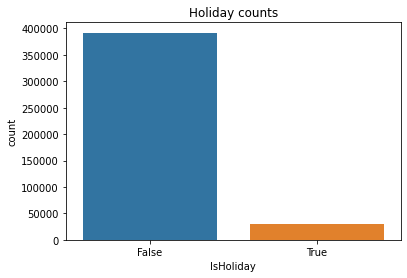

In [ ]:
sns.countplot(train_data['IsHoliday'])
plt.title('Holiday counts')
plt.show()

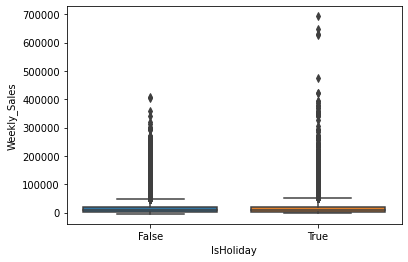

In [ ]:
sns.boxplot(x='IsHoliday',y='Weekly_Sales',data=train_data)
plt.show()

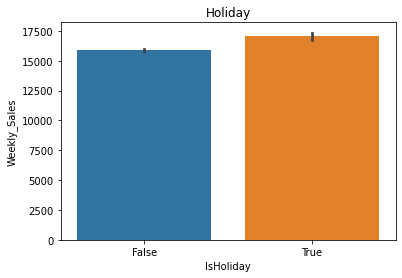

In [ ]:
df = train_data.sort_values('Weekly_Sales')
sns.barplot(x='IsHoliday',y='Weekly_Sales',data=df)
plt.title("Holiday")
plt.show()

**Obsevation**
* Form above plots we can see that without holiday datapoints are more than holiday datapoints
* WeeklySales is higher on holiday week

In [ ]:
print("Avg. Weekly Sales on Non Holiday ",np.mean(train_data['Weekly_Sales'][(train_data['IsHoliday'] == False)]))
print("Avg. Weekly Sales on Holiday ",np.mean(train_data['Weekly_Sales'][(train_data['IsHoliday'] == True)]))

Avg. Weekly Sales on Non Holiday  15901.445069008516
Avg. Weekly Sales on Holiday  17035.82318735048


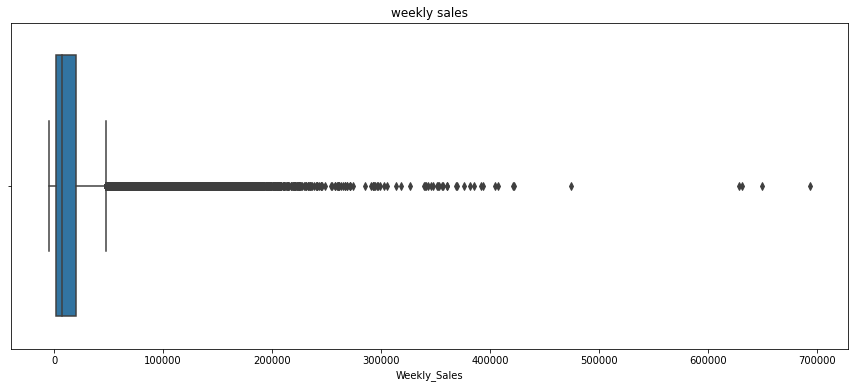

In [ ]:
plt.figure(figsize=(15,6))
sns.boxplot(train_data['Weekly_Sales'])
plt.title('weekly sales')
plt.show()

**Observation**
* Boxplot for weekly sales . We can clearly see that weekly sales mean 25th 75 th percentile values are less than 10k and only few point are greater thatn 40k
* Largest Weekly sell is around 68k

#### Store

In [ ]:
print("Total number of stores: ",len(np.unique(train_data['Store'])))

Total number of stores:  45


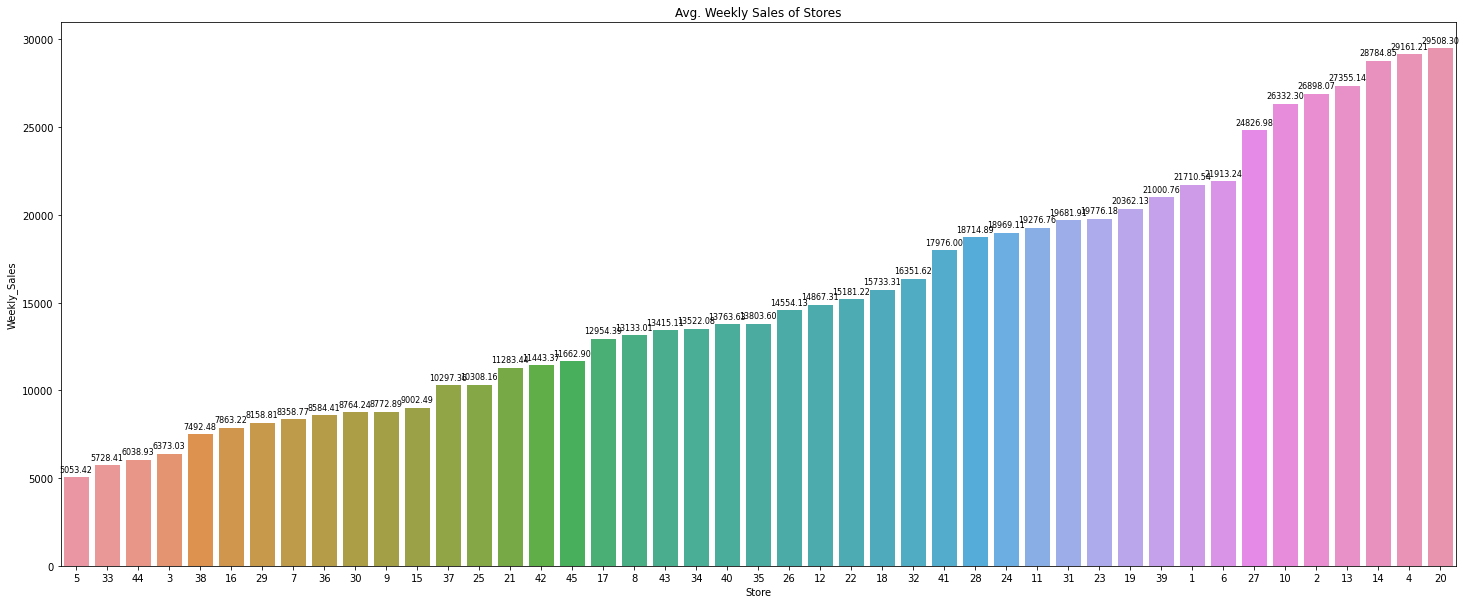

In [ ]:
#https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/ Refrence to show annotation in bar plot
plt.figure(figsize=(25,10))

data_store = train_data.groupby('Store').mean().sort_values('Weekly_Sales').reset_index()

# plots = sns.barplot(y='Weekly_Sales',x='Store',data=data)
plots = sns.barplot(y='Weekly_Sales',x=data_store['Store'],data=data_store,order=data_store['Store'])

for bar in plots.patches:
    
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
plt.title("Avg. Weekly Sales of Stores")   
plt.show()

**Observation**
* Plot Shows average weekly sales of every store
* some store have high sales and some store have less
* store number 20 have highest sale
* Store 5 have less sale

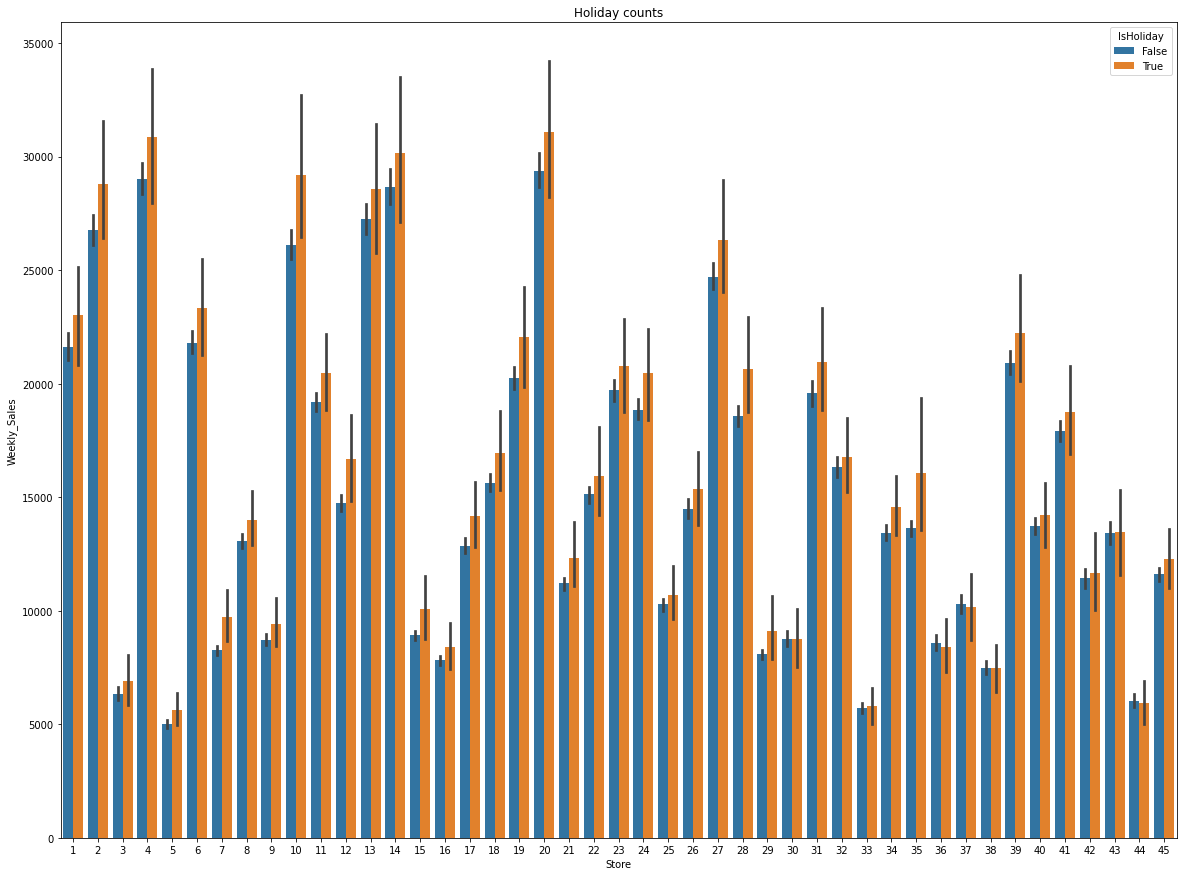

In [ ]:
plt.figure(figsize=(20,15))
sns.barplot(x='Store',y='Weekly_Sales',hue='IsHoliday',data=train_data)
plt.title('Holiday counts')
plt.show()

**Observation:**
* In this plot we have compared Holiday week and Non Holiday week data for every store
* In all the store count on holiday week sale is high

#### Dept

In [ ]:
print("Total number of dept",len(np.unique(train_data['Dept'])))

Total number of dept 81


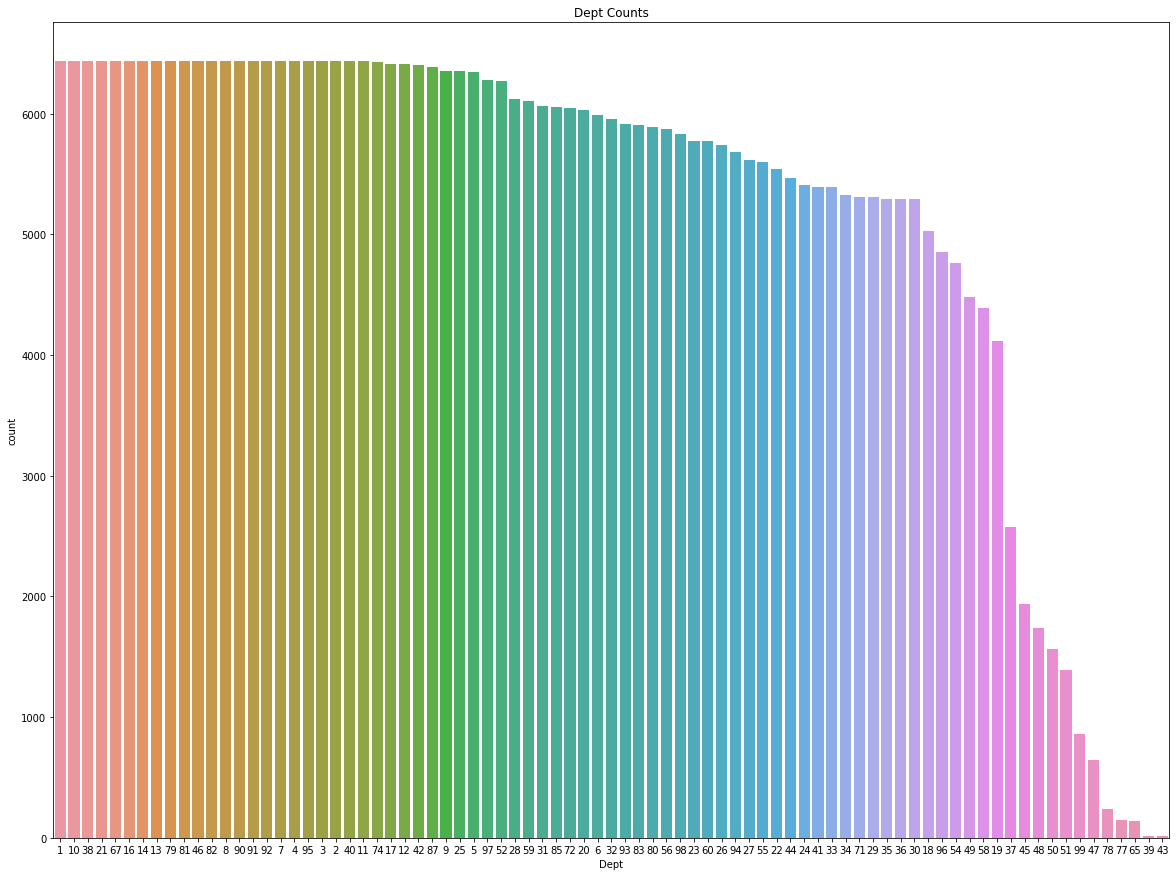

In [ ]:
plt.figure(figsize=(20,15))
sns.countplot(x='Dept',data=train_data,order = train_data['Dept'].value_counts().index)
plt.title("Dept Counts")
plt.show()

**Observation**
* we can see tha dept 9 have less number of data and some have large
* We can see imbalance between Dept

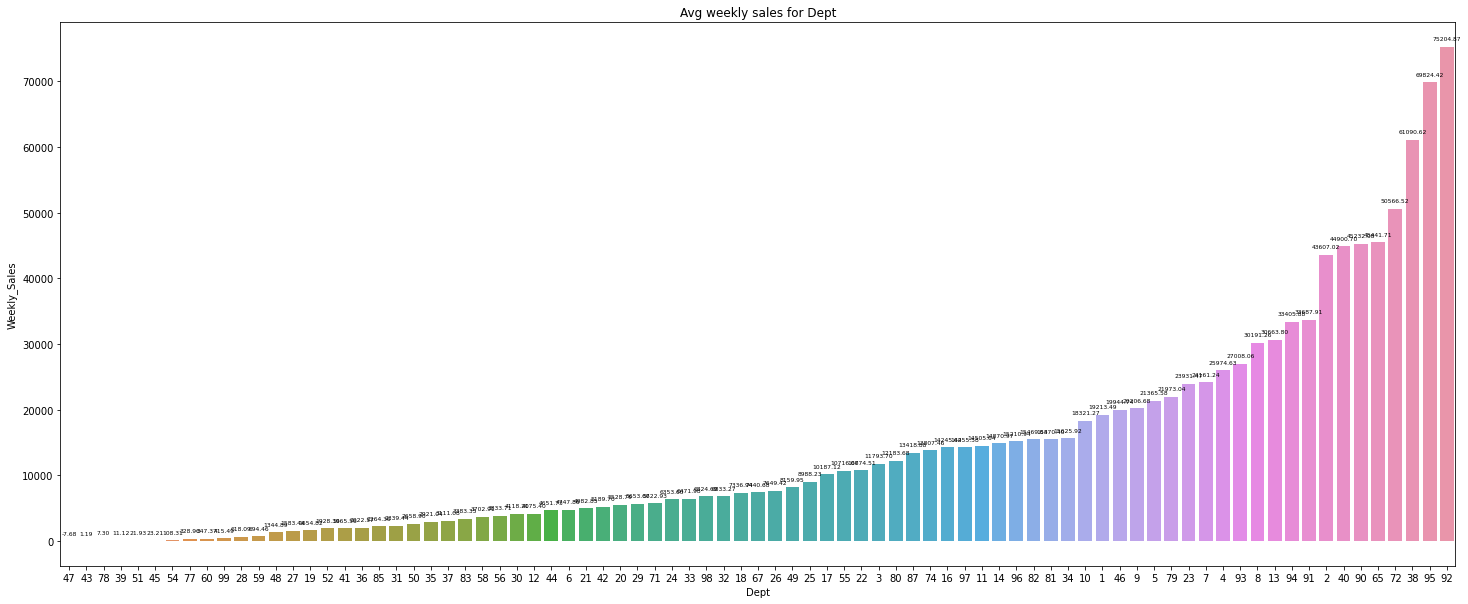

In [ ]:
plt.figure(figsize=(25,10))

data_dept = train_data.groupby('Dept').mean().sort_values('Weekly_Sales').reset_index()

# plots = sns.barplot(y='Weekly_Sales',x='Store',data=data)
plots = sns.barplot(y='Weekly_Sales',x=data_dept['Dept'],data=data_dept,order=data_dept['Dept'])

for bar in plots.patches:
    
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=6, xytext=(0, 8),
                   textcoords='offset points')
plt.title("Avg weekly sales for Dept")
plt.show()

**Observation**
* We can see that average weekly sale of dept 92 is very high and dept 45 have very low

#### Type

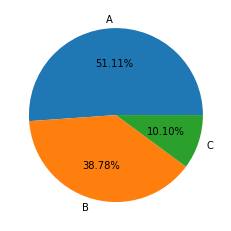

In [ ]:
plt.pie(train_data['Type'].value_counts(),labels=train_data['Type'].value_counts().index,autopct='%0.2f%%')
plt.show()

**Observation**
* We can clearly see from pie that almost 50% of data have type A and only 10% of data have Type C

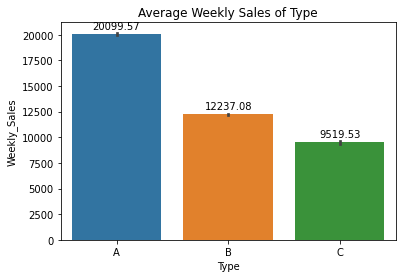

In [ ]:
plots = sns.barplot(x='Type',y='Weekly_Sales',data=train_data)
for bar in plots.patches:
    
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
plt.title("Average Weekly Sales of Type")
plt.show()

**Observation**
* Average Weekly Sale for Type A is Higher than B and Average Sale of Type B is higher than Type C

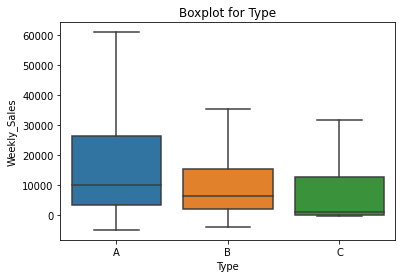

In [ ]:
#Boxplot of Type
sns.boxplot(x='Type',y='Weekly_Sales',data=train_data,showfliers=False)
plt.title("Boxplot for Type")
plt.show()

#### Size of dept 

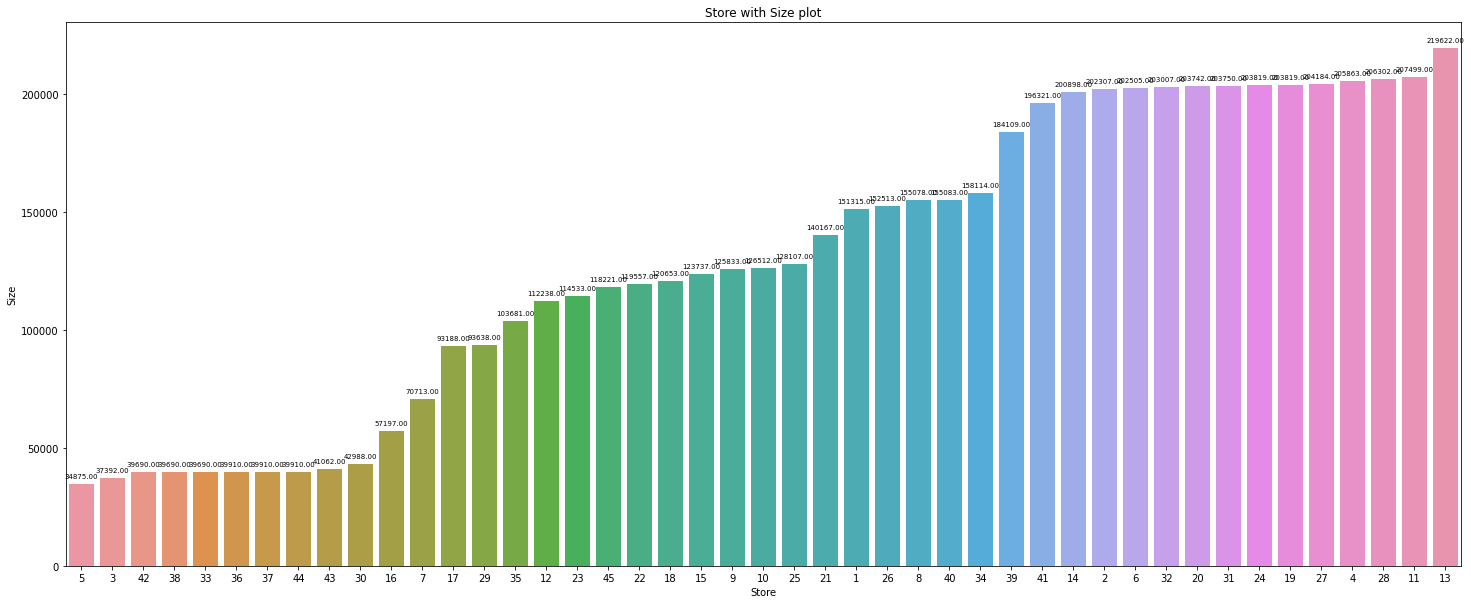

In [ ]:
plt.figure(figsize=(25,10))
data_size = train_data.groupby('Store').mean().sort_values('Size').reset_index()
plots = sns.barplot(x='Store',y='Size',data=data_size,order=data_size['Store'])
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=7, xytext=(0, 8),
                   textcoords='offset points')
plt.title("Store with Size plot")
plt.show()

**Observation**
* Store 13 is largest in size
* Some store have large size and some have low. No Store s extrem larger or some store is not too small

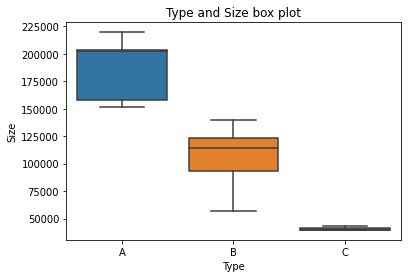

In [ ]:
sns.boxplot(x='Type',y='Size',data=train_data,showfliers=False)
plt.title("Type and Size box plot")
plt.show()

**Observation**
* Clearly see that type of A hhave larger size of store than B and C
* Clearly seprate points with size and type data

#### Temprature

[]

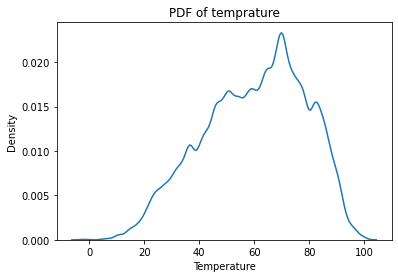

In [ ]:
sns.kdeplot(train_data['Temperature'])
plt.title("PDF of temprature")
plt.plot()

**Observation**
* avg. temprature is around 70 
* Min temprature is in minus and max can go up to 100
* we can see wide spread for temprature but 20% of point have around 70

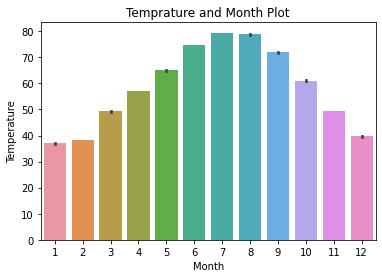

In [ ]:
sns.barplot(x='Month',y='Temperature',data=train_data)
plt.title("Temprature and Month Plot")
plt.show()

**Observation**
* We can see average temprature for all months
* Temrature in middle of year is higher than start and end of year as mid of year is summer
* Average min temprature is around 37 no avg

#### Fuel_Price

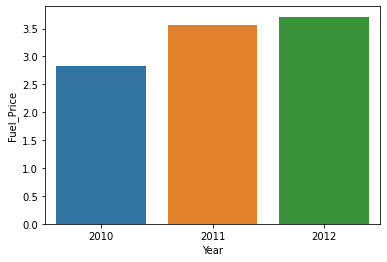

In [ ]:
sns.barplot(x='Year',y='Fuel_Price',data=train_data)
plt.show()

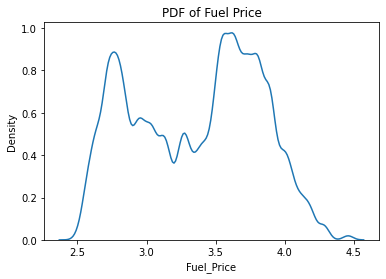

In [ ]:
sns.kdeplot(train_data['Fuel_Price'])
plt.title("PDF of Fuel Price")
plt.show()

**Observation**
* Every year price is increasing
* Most points are at 2.8 and 3.7
* Fuel Price range is between 2.5 to 4.5


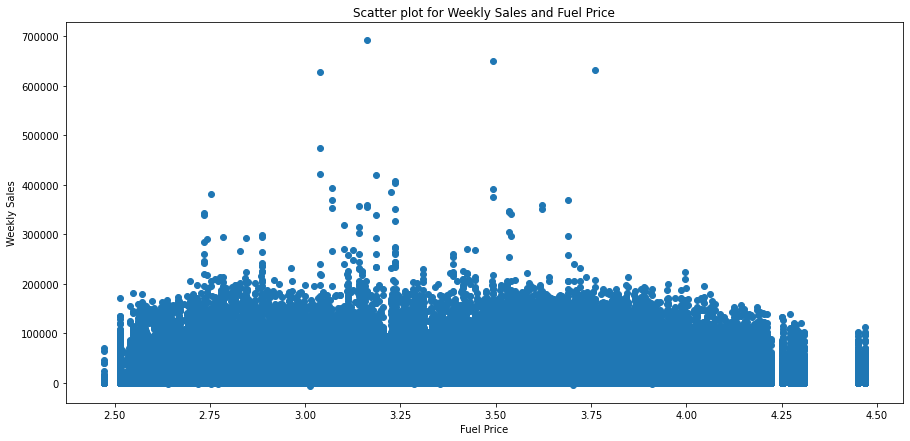

In [ ]:
plt.figure(figsize=(15,7))
plt.scatter(x='Fuel_Price',y='Weekly_Sales',data=train_data)
plt.xlabel("Fuel Price")
plt.ylabel("Weekly Sales")
plt.title("Scatter plot for Weekly Sales and Fuel Price")
plt.show()


**Observation**
* This plot does not give clear instution as points are overlapperd

#### Unemployment

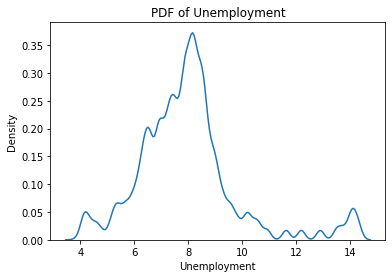

In [ ]:
sns.kdeplot(train_data['Unemployment'])
plt.title("PDF of Unemployment")
plt.show()

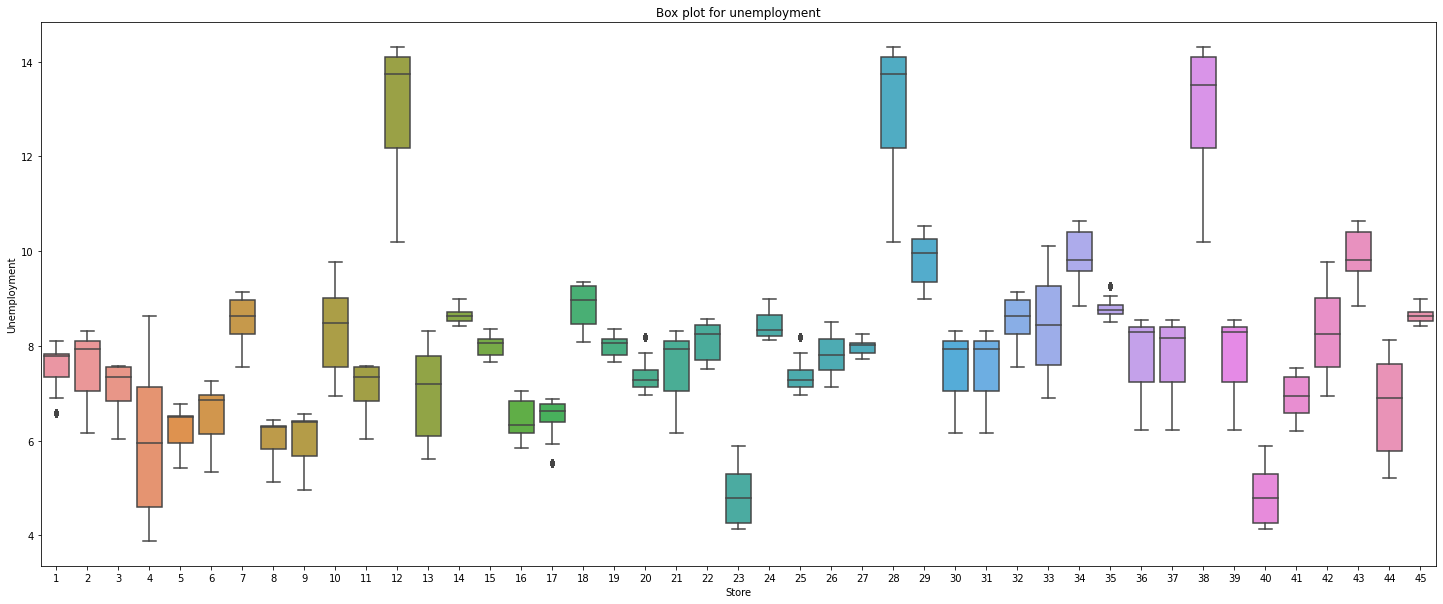

In [ ]:
plt.figure(figsize=(25,10))
sns.boxplot(x = 'Store',y='Unemployment',data=train_data)
plt.title("Box plot for unemployment")
plt.show()

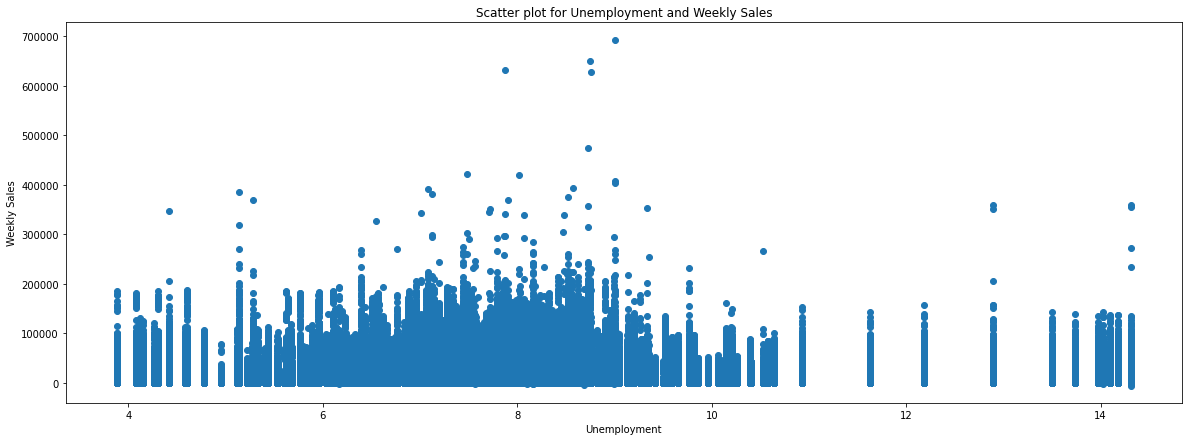

In [ ]:
plt.figure(figsize=(20,7))
plt.scatter(y=train_data['Weekly_Sales'],x=train_data['Unemployment'])
plt.xlabel("Unemployment")
plt.ylabel("Weekly Sales")
plt.title("Scatter plot for Unemployment and Weekly Sales")
plt.show()

**Observation**
* From above plots we can see that Every store have different Unemployment rate some how we will able to seprate them .which can be good for model building
* Scatter plot for Weekly sales and UNemployment rate

#### WeeklySales

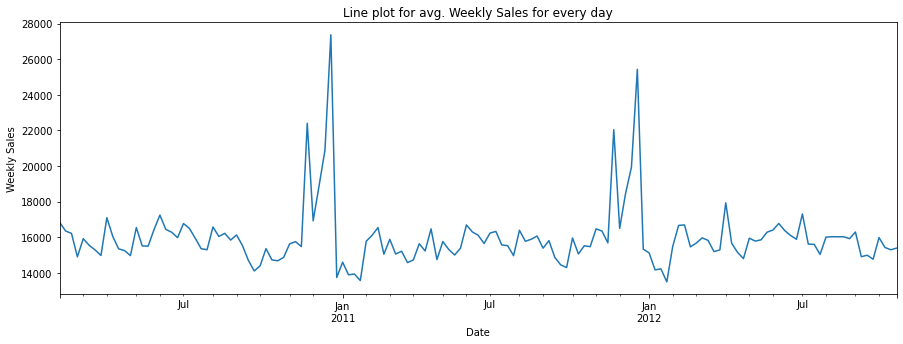

In [ ]:
plt.figure(figsize=(15,5))
train_data.groupby('Date').mean()['Weekly_Sales'].plot(kind='line')
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("Line plot for avg. Weekly Sales for every day")
plt.show()

**Observation**
* This plot is for all date vs avg. Weekly Sales in stores. it shows sales in last 2 months is higher than other months also year 2012 monthly sale is less than 2011 monthly sale

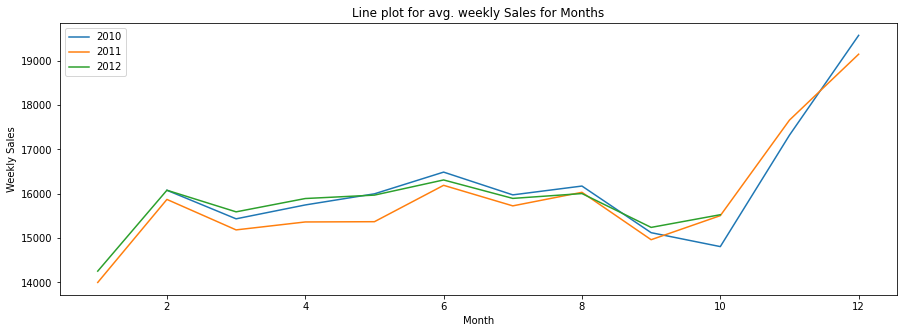

In [ ]:
plt.figure(figsize=(15,5))
train_data[train_data['Year']==2010].groupby('Month').mean()['Weekly_Sales'].plot(kind='line')
train_data[train_data['Year']==2011].groupby('Month').mean()['Weekly_Sales'].plot(kind='line')
train_data[train_data['Year']==2012].groupby('Month').mean()['Weekly_Sales'].plot(kind='line')
plt.legend(['2010','2011','2012'])
plt.ylabel("Weekly Sales")
plt.title("Line plot for avg. weekly Sales for Months")
plt.show()

**Observation**

* Sale of last 2 month is higher than other months because Mostly end of year sale and more holidays are their in last few months
* In last month of every year Sale is high
* In every year sale is lower in month of 10 I guess because people wait for end of year sale

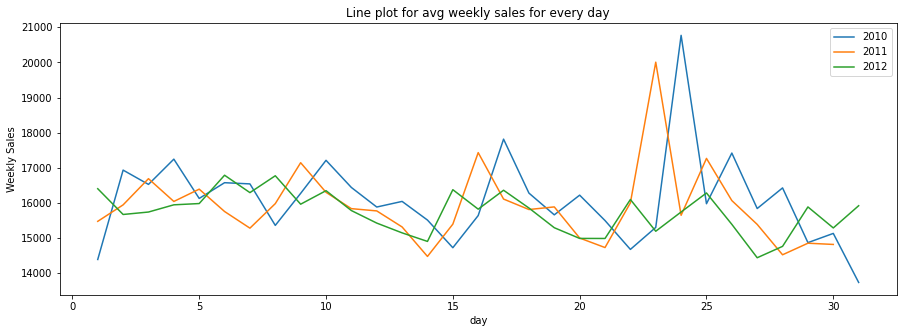

In [ ]:
plt.figure(figsize=(15,5))
train_data[train_data['Year']==2010].groupby('day').mean()['Weekly_Sales'].plot(kind='line')
train_data[train_data['Year']==2011].groupby('day').mean()['Weekly_Sales'].plot(kind='line')
train_data[train_data['Year']==2012].groupby('day').mean()['Weekly_Sales'].plot(kind='line')
plt.legend(['2010','2011','2012'])
plt.ylabel("Weekly Sales")
plt.title("Line plot for avg weekly sales for every day")
plt.show()

**Observation**



* Sale of 20-25 date higher
* Sale of 15-20 date is little lower because I think people want to delay to 20-25
* in 2012 sale is more consistent than other two

<Figure size 720x720 with 0 Axes>

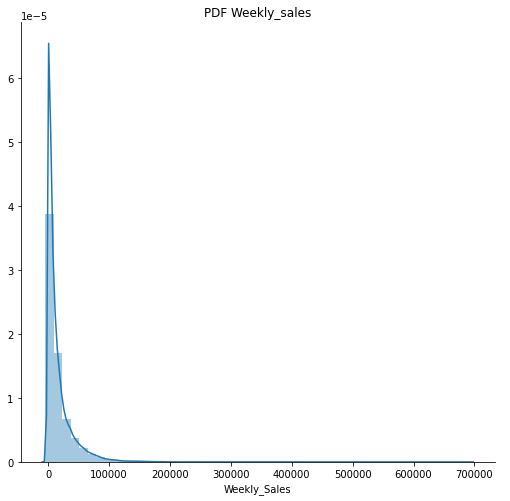

In [ ]:
plt.figure(figsize=(10,10))
sns.FacetGrid(train_data, height=7).map(sns.distplot, "Weekly_Sales").add_legend()
plt.title("PDF Weekly_sales")
plt.show()

**Observation**
* Disb of weekly sale is peakered around 0 to 2000 .Verly little weekly sale is larger than 20k

In [ ]:
#Weekly Sales at each percntile 0,10,20,30,40,50,60,70,80,90,100 

print("Percentile for HOliday true")
var =train_data[train_data['IsHoliday']==True]["Weekly_Sales"].values
for i in range(0,100,10):
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])
print("\n")

print("Percentile for Non Holiday true")
#Weekly Sales each percntile 0,10,20,30,40,50,60,70,80,90,100 
var =train_data[train_data['IsHoliday']==False]["Weekly_Sales"].values
for i in range(0,100,10):
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

Percentile for HOliday true
0 percentile value is -798.0
10 percentile value is 307.95
20 percentile value is 1356.56
30 percentile value is 2920.57
40 percentile value is 4947.13
50 percentile value is 7947.74
60 percentile value is 11971.49
70 percentile value is 17420.62
80 percentile value is 26079.96
90 percentile value is 43859.53
100 percentile value is  693099.36


Percentile for Non Holiday true
0 percentile value is -4988.94
10 percentile value is 290.4
20 percentile value is 1339.55
30 percentile value is 2912.83
40 percentile value is 4884.71
50 percentile value is 7589.95
60 percentile value is 11221.34
70 percentile value is 16563.48
80 percentile value is 25147.5
90 percentile value is 42753.39
100 percentile value is  406988.63


**Observation**
* Weekly sales for every year is almost same just in start and in middle of 2011 weekly sale was little low than other two
* In every year sale is lower in month of 10 I guess because people wait for end of year sale

## 4. Feature Engineering

#### Negative Sales

In [ ]:
print("Total data point have negative sale",sum(train_data['Weekly_Sales']<0))

Total data point have negative sale 1285


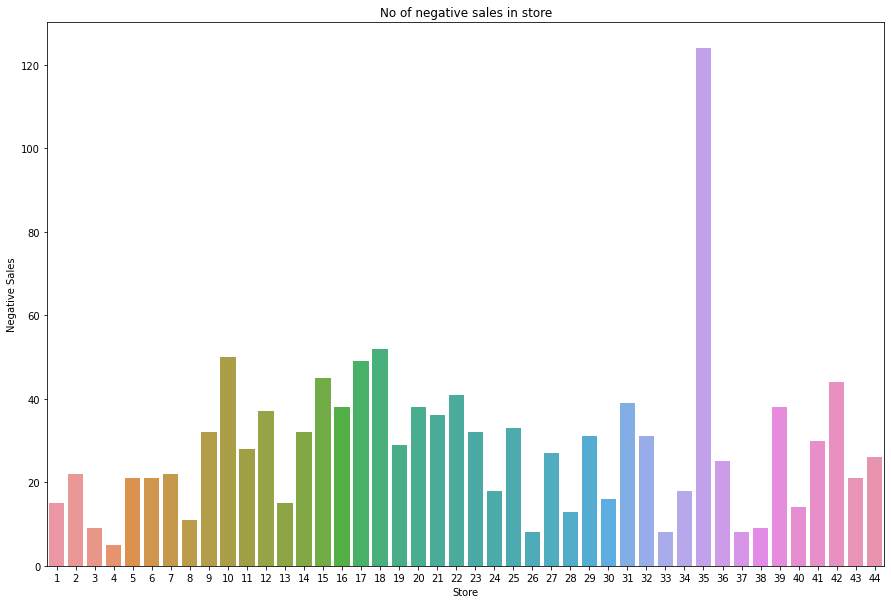

In [ ]:
a = []
store_len = len(np.unique(train_data['Store']))
for x in range(1,store_len):
  a.append(len(train_data.loc[(train_data['Store']==x) & (train_data['Weekly_Sales']<0)]))

plt.figure(figsize=(15,10))
sns.barplot(x=list(range(1,store_len)),y=a)
plt.xlabel("Store")
plt.ylabel("Negative Sales")
plt.title("No of negative sales in store")
plt.show()

**Observation**
* Store 35 have highest number of negative sales
* Every Store have negative sales 
* This negative sale or sale zero is I think because of return of item (dameged item soled or anything)

#### Holidays Data EDA

In [ ]:
from datetime import datetime

train_data['Super_Bowl'] = np.where(
(train_data['Date']==datetime(2010,2,12))|
(train_data['Date'] == datetime(2011,2,11))|
(train_data['Date'] == datetime(2012,2,10))|
(train_data['Date'] == datetime(2013,2,8)), 1, 0)

train_data['Labors_Day'] = np.where(
(train_data['Date']==datetime(2010,9,10))|
(train_data['Date'] == datetime(2011,9,9))|
(train_data['Date'] == datetime(2012,9,7))|
(train_data['Date'] == datetime(2013,9,6)), 1, 0)

train_data['Thanksgiving'] = np.where(
(train_data['Date']==datetime(2010,11,26))|
(train_data['Date'] == datetime(2011,11,25))|
(train_data['Date'] == datetime(2012,11,23))|
(train_data['Date'] == datetime(2013,11,29)), 1, 0)

train_data['Christmas'] = np.where(
(train_data['Date']==datetime(2010,12,31))|
(train_data['Date'] == datetime(2011,12,30))|
(train_data['Date'] == datetime(2012,12,28))|
(train_data['Date'] == datetime(2013,12,27)), 1, 0)

In [ ]:
# //Cross check that all holidays are covered or not
train_data["Super_Bowl"].sum() + train_data["Labors_Day"].sum() + train_data["Thanksgiving"].sum()+ train_data["Christmas"].sum() == (train_data['IsHoliday']==True).sum()

True

In [ ]:
mean_weekly_non_holiday = np.mean(train_data['Weekly_Sales'][(train_data['Super_Bowl']==0)&(train_data['Labors_Day']==0)&(train_data['Thanksgiving']==0)&(train_data['Christmas']==0)])
print("Average sale of Non Holiday: ",)

super_bowl_mean = np.mean(train_data['Weekly_Sales'][(train_data['Super_Bowl']==1)])
Labours_mean = np.mean(train_data['Weekly_Sales'][(train_data['Labors_Day']==1)])
ThanksGiving_mean = np.mean(train_data['Weekly_Sales'][(train_data['Thanksgiving']==1)])
Christmas_mean = np.mean(train_data['Weekly_Sales'][(train_data['Christmas']==1)])

print("Average sale of Superbowl week: ",np.round(super_bowl_mean,2))
print("Average sale of Labours day week: ",np.round(Labours_mean,2))
print("Average sale of Thanksgiving day week: ",np.round(ThanksGiving_mean,2))
print("Average sale of Christmas day week: ",np.round(Christmas_mean,2))

Average sale of Non Holiday: 
Average sale of Superbowl week:  16378.0
Average sale of Labours day week:  15881.69
Average sale of Thanksgiving day week:  22220.94
Average sale of Christmas day week:  14543.39


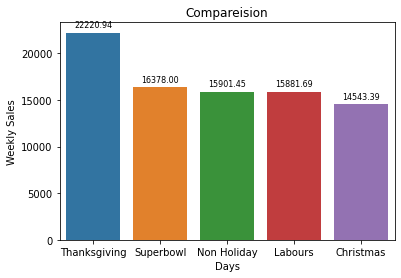

In [ ]:
plots = sns.barplot(["Thanksgiving",'Superbowl',"Non Holiday",'Labours','Christmas'],[ThanksGiving_mean,super_bowl_mean,mean_weekly_non_holiday,Labours_mean,Christmas_mean])
plt.title("Compareision")
plt.xlabel("Days")
plt.ylabel("Weekly Sales")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
plt.show()

**Observation**
* Avg. Thanksgiving day weekly sale is higher than others
* All other days and Non Holiday week sale is almost same

#### Convert into log feature

In [ ]:
train_data['Weekly_Sales2'] = train_data['Weekly_Sales'].map(lambda x:0.001 if x <= 0 else x)

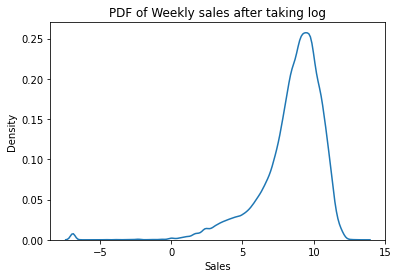

In [ ]:
train_data['Sales'] = np.log(train_data['Weekly_Sales2'])
sns.kdeplot(train_data['Sales'])
plt.title("PDF of Weekly sales after taking log")
plt.show()

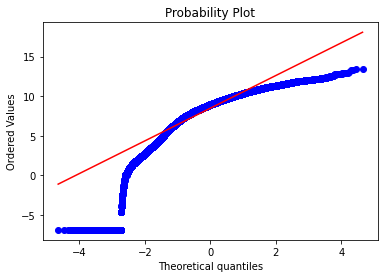

In [ ]:
from scipy import stats
ax = stats.probplot(train_data['Sales'],dist='norm',plot=plt)
plt.show()

#### Extra Holidays

In [ ]:
# https://www.geeksforgeeks.org/python-holidays-library/
import holidays

In [ ]:
# from datetime import timedelta
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])
train_data['Week_last_Date'] = train_data['Date'] + pd.DateOffset(days=6) #adding last date in dataframe
test_data['Week_last_Date'] = test_data['Date'] + pd.DateOffset(days=6) #adding last date in dataframe

In [ ]:
def count_number_holiday(start,end):
  """This function is used to get number of holiday from start date to end date"""
  return len(holidays.UnitedStates()[start:end])

In [ ]:
def numbers(df):
  """This takes dataframe and giving total number of holidays in week for every point"""
  num_holidays = []
  for idx,data in df.iterrows():
    num_holidays.append(count_number_holiday(data['Date'],data['Week_last_Date']))
  return num_holidays
  

In [ ]:
train_data['Count_Holiday'] = numbers(train_data)
test_data['Count_Holiday'] = numbers(test_data)

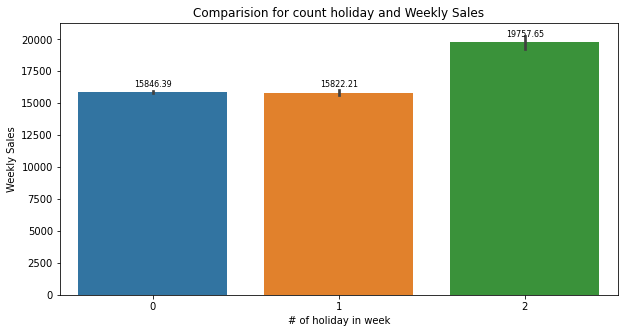

In [ ]:
plt.figure(figsize=(10,5))
plots = sns.barplot(x='Count_Holiday',y='Weekly_Sales',data=train_data)
plt.title("Comparision for count holiday and Weekly Sales")
plt.xlabel("# of holiday in week")
plt.ylabel("Weekly Sales")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
plt.show()

**Observation**
* Mostly in a week there is max number of 2 holidays and sale on those 2 days week Weekly sale is higher
* they are not much difference in sales so bur if it have 2 holidays it is more helping 
* 0 holiday week means there is not extra holiday in those weeks

#### Advance EDA

Taking fuel price and converting it into bins

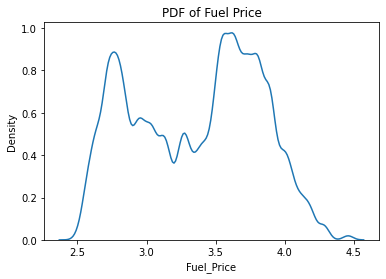

In [ ]:
sns.kdeplot(train_data['Fuel_Price'])
plt.xlabel("Fuel_Price")
plt.ylabel("Density")
plt.title("PDF of Fuel Price")
plt.show()

* This help us to Decide number of bins for our task

In [ ]:
counts, bin_edges = np.histogram(train_data['Fuel_Price'], bins=4, 
                                 density = True)
train_data['Fuel_bins'] = pd.cut(train_data['Fuel_Price'], bin_edges)

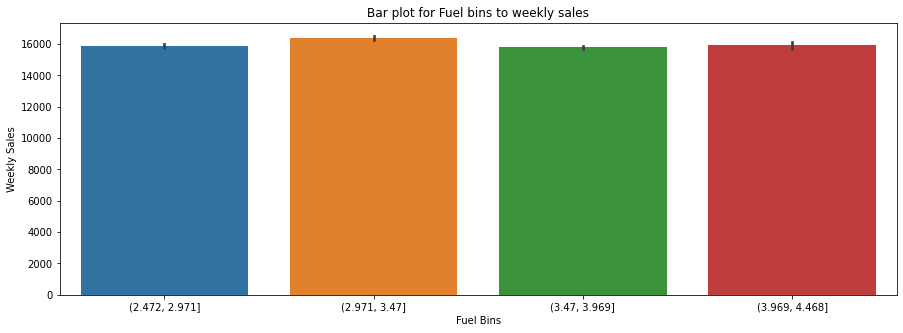

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x='Fuel_bins',y='Weekly_Sales',data=train_data)
plt.xlabel("Fuel Bins")
plt.ylabel("Weekly Sales")
plt.title("Bar plot for Fuel bins to weekly sales")
plt.show()

**Observation**
* Avg. weekly sale for all this Fuel range and they are almost same no much information 

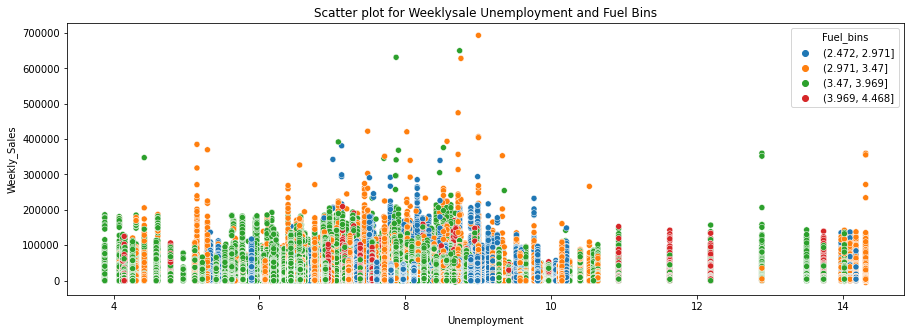

In [ ]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=train_data, x="Unemployment", y="Weekly_Sales", hue="Fuel_bins")
plt.title("Scatter plot for Weeklysale Unemployment and Fuel Bins")
plt.show()

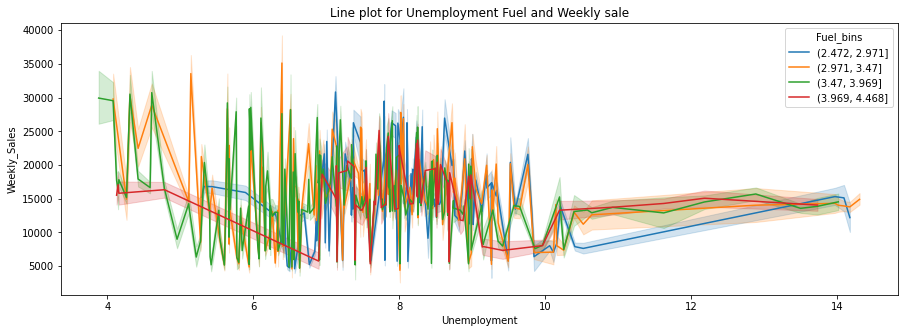

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(data=train_data, x="Unemployment", y="Weekly_Sales",hue='Fuel_bins')
plt.title("Line plot for Unemployment Fuel and Weekly sale")
plt.show()

**Observation**
* more ups and down in weekly sale for unemployment rate is around 8
* when unemployment rate is high we can observe that weekly sale is less . People not want to buy even if petrol price is low
* 2.97-3.47 bin have more weekly sale

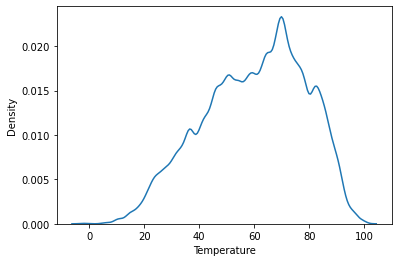

In [ ]:
sns.kdeplot(train_data['Temperature'])
plt.show()

In [ ]:
names = ['10', '30', '50', '70', '90']
counts, bin_edges = np.histogram(train_data['Temperature'], bins=5,density = True)
train_data['Temp'] = pd.cut(train_data['Temperature'], bin_edges, labels=names)

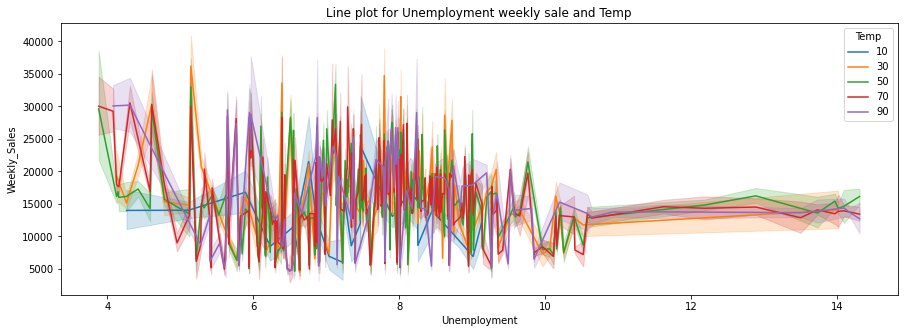

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(data=train_data, x="Unemployment", y="Weekly_Sales",hue='Temp')
plt.title("Line plot for Unemployment weekly sale and Temp")
plt.show()

Taking Fuel temprature as bins with weekly sales

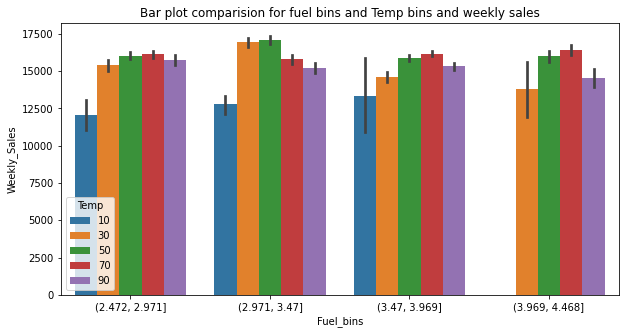

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='Fuel_bins',y='Weekly_Sales',data=train_data,hue='Temp')
plt.title("Bar plot comparision for fuel bins and Temp bins and weekly sales")
plt.show()

**Observation**
* Claerly see that when temprature is not much higher and not much lower weekly sale is higher and also same time when fuel price is lower Weekly sales 
* when fuel price ishigher and temp is also lowest or highest low weekly sales

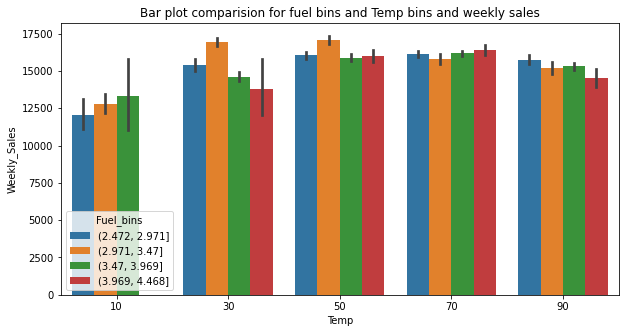

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='Temp',y='Weekly_Sales',data=train_data,hue='Fuel_bins')
plt.title("Bar plot comparision for fuel bins and Temp bins and weekly sales")
plt.show()

**Observation**
* when temprature is low no sale for highest fuel bins
* when tempratur is around 50-70 sale is good for all fuel price

#### Final Observation
* Holiday week have more weekly sales than non holiday weekly sales
* Fuel price and year are correlated with eachother
* Weekly Sale of Last 2 month is higher
* Fuel Price is increasing year by year
* Temprature in middle year is higher and weekly sale of higher temprature and lowest temprature is lower
* Higher unemployment rate have little less Weekly sales
* Size and Type of store is clearly differntiable and A type have more weekly sale than other two
* Weekly sale in 20-25 date is higher 
* Store and Unemployment rate have some relation as store location change region in that state would have more or less unemployment rate than other
* there are some negative sales may be people return purchased item
* Different store and different dept have different avg weekly sales so selecting store is also good

#### Create Lag feature

Adding lagged feature 
ref.:- https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/

In [ ]:
def create_lag_feature(df):
  '''This Function will take data frame and add 1 day lag feature'''
  '''If first data point is of another store it will calculate mean of that store sales of that year else it will take previous weekly sale'''
  currentStore = -1
  arr = []
  for index, row in df.iterrows():
    if index == 0 or currentStore != row['Store']:
      arr.append(df[(df['Year']==row['Year']) & (df['Store']==row['Store'])].mean()['Weekly_Sales'])
      currentStore = row['Store']
    else:
      # print(index)
      arr.append(df.iloc[index-1]['Weekly_Sales'])

  return arr

## Preprocessed Data

In [ ]:
def preprocessedData(dataframe):
  """This fuction is used to preprocess data"""
  
  #As above EDA adding features
  dataframe['Date'] = pd.to_datetime(dataframe['Date'])
  dataframe['Month'] = dataframe['Date'].dt.month
  dataframe['Year'] = dataframe['Date'].dt.year
  dataframe['day'] = dataframe['Date'].dt.day
  
  dataframe['Super_Bowl'] = np.where(
  (dataframe['Date']==datetime(2010,2,12))|
  (dataframe['Date'] == datetime(2011,2,11))|
  (dataframe['Date'] == datetime(2012,2,10))|
  (dataframe['Date'] == datetime(2013,2,8)), 1, 0)

  dataframe['Labors_Day'] = np.where(
  (dataframe['Date']==datetime(2010,9,10))|
  (dataframe['Date'] == datetime(2011,9,9))|
  (dataframe['Date'] == datetime(2012,9,7))|
  (dataframe['Date'] == datetime(2013,9,6)), 1, 0)

  dataframe['Thanksgiving'] = np.where(
  (dataframe['Date']==datetime(2010,11,26))|
  (dataframe['Date'] == datetime(2011,11,25))|
  (dataframe['Date'] == datetime(2012,11,23))|
  (dataframe['Date'] == datetime(2013,11,29)), 1, 0)

  dataframe['Christmas'] = np.where(
  (dataframe['Date']==datetime(2010,12,31))|
  (dataframe['Date'] == datetime(2011,12,30))|
  (dataframe['Date'] == datetime(2012,12,28))|
  (dataframe['Date'] == datetime(2013,12,27)), 1, 0)

  #Converting type and holiday into categorical to numerical
  dataframe['Type'] = dataframe['Type'].map({'A':3,'B':2,'C':1})
  dataframe['IsHoliday'] = dataframe['IsHoliday'].map({True:1,False:0})
  # dataframe['lagged'] = create_lag_feature(dataframe)
  dataframe[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']] = dataframe[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
  dataframe = dataframe.drop(['Date','CPI','Unemployment','Week_last_Date'],axis=1)
  return dataframe

In [ ]:
train_data = preprocessedData(train_data)

In [ ]:
test_data = preprocessedData(test_data)

In [ ]:
train_data.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Count_Holiday,Month,Year,day,Super_Bowl,Labors_Day,Thanksgiving,Christmas
0,1,1,24924.50,0,3,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,0,2,2010,5,0,0,0,0
1,1,1,46039.49,1,3,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,1,2,2010,12,1,0,0,0
2,1,1,41595.55,0,3,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,0,2,2010,19,0,0,0,0
3,1,1,19403.54,0,3,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,0,2,2010,26,0,0,0,0
4,1,1,21827.90,0,3,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,0,3,2010,5,0,0,0,0


In [ ]:
# train_data.isnull().sum()

## Feature Importance and selection

In [ ]:
train_data.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Month', 'Year', 'day',
       'Super_Bowl', 'Labors_Day', 'Thanksgiving', 'Christmas'],
      dtype='object')

In [ ]:
y = train_data['Weekly_Sales']
x = train_data.drop(['Weekly_Sales','Date','Week_last_Date','Fuel_bins'],axis=1)

KeyError: ignored

In [ ]:
x = x[:20000]
y = y[:20000]

In [ ]:
from sklearn.feature_selection import mutual_info_regression
mutal_info = mutual_info_regression(x,y)
# fr.fit(x,y)
mutal_info

array([3.58888272e-02, 1.67151595e+00, 3.25496668e-03, 4.16504336e-05,
       3.50679093e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.78881519e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.73912345e-02, 9.95676735e-03, 1.34868732e-02,
       0.00000000e+00, 1.22545619e-03, 0.00000000e+00, 1.57121153e-03,
       4.65255191e-04])

In [ ]:
mutal_info = pd.Series(mutal_info)
mutal_info.index = x.columns
mutal_info.sort_values(ascending=False)

Dept            1.671516
Unemployment    0.057391
Store           0.035889
Size            0.035068
Year            0.013487
Month           0.009957
IsHoliday       0.003255
MarkDown3       0.002789
Thanksgiving    0.001571
Super_Bowl      0.001225
Christmas       0.000465
Type            0.000042
MarkDown5       0.000000
MarkDown2       0.000000
MarkDown1       0.000000
Fuel_Price      0.000000
Temperature     0.000000
CPI             0.000000
day             0.000000
Labors_Day      0.000000
MarkDown4       0.000000
dtype: float64

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
lst = pd.Series(np.abs(lr.coef_))
lst.index = x.columns
lst.sort_values(ascending=False)

Sales            3.299872e+00
Unemployment     1.042777e+00
Weekly_Sales2    9.998726e-01
Year             9.338187e-01
Fuel_Price       8.153022e-01
IsHoliday        3.877414e-01
Christmas        3.605203e-01
CPI              2.926350e-01
Count_Holiday    2.138888e-01
Super_Bowl       4.123971e-02
Thanksgiving     3.802343e-02
Labors_Day       2.400490e-02
Dept             2.145852e-02
Temperature      1.922236e-02
day              1.684817e-02
Month            7.965111e-03
Temp             5.280392e-03
MarkDown5        3.461076e-05
MarkDown3        1.565053e-05
MarkDown4        1.184692e-05
Size             7.775278e-06
MarkDown2        3.542148e-06
MarkDown1        6.111290e-07
Store            1.524800e-10
Type             7.778639e-13
dtype: float64

In [ ]:
train_data.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Month', 'Year', 'day',
       'Super_Bowl', 'Labors_Day', 'Thanksgiving', 'Christmas',
       'Weekly_Sales2', 'Sales', 'Week_last_Date', 'Count_Holiday',
       'Fuel_bins', 'Temp'],
      dtype='object')

#### Correlation for numeric

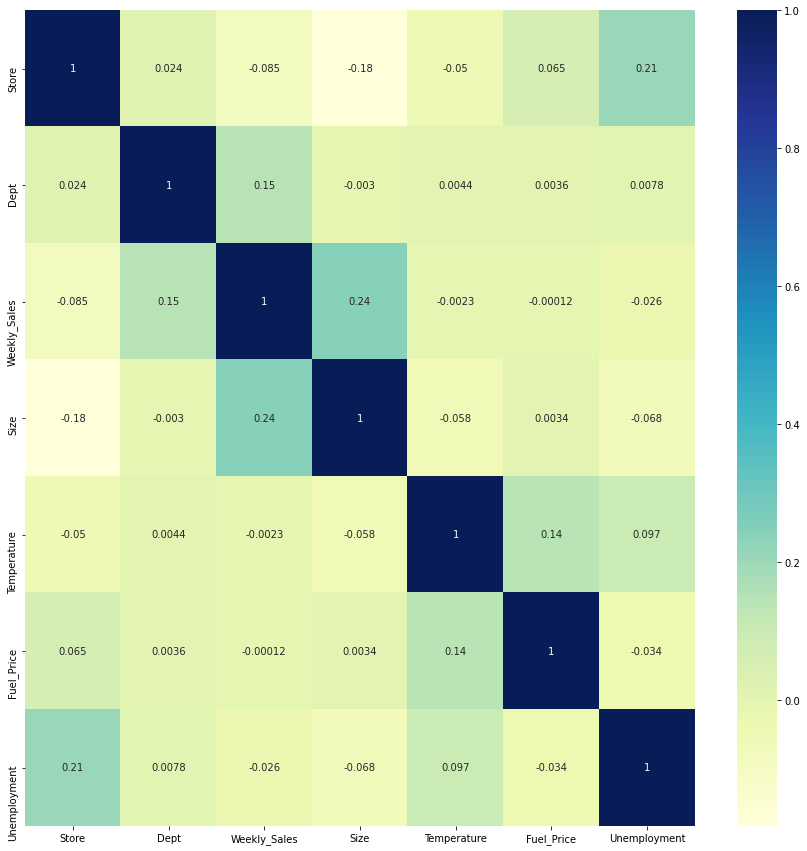

In [ ]:
lst_numeric = ['Store','Dept','Weekly_Sales','Size','Temperature','Fuel_Price','Unemployment']
plt.figure(figsize=(15,15))
sns.heatmap(train_data[lst_numeric].corr(),annot=True,cmap='YlGnBu')
plt.show()

#### Correlation for Categorical and numeric

In [ ]:
from scipy.stats import pointbiserialr

pbc = pointbiserialr(train_data['Store'], train_data['Weekly_Sales'])
pbc

PointbiserialrResult(correlation=-0.0851949918324115, pvalue=0.0)

In [ ]:
pbc = pointbiserialr(train_data['IsHoliday'], train_data['Weekly_Sales'])
pbc

PointbiserialrResult(correlation=0.012774220374854778, pvalue=1.0912222668460193e-16)

In [ ]:
import statsmodels.api as smf
from statsmodels.formula.api import ols
# relate_df = df3[['lifeexpectancy', 'internetuserate_bins']]

anova = ols(formula='Weekly_Sales~Temperature+Fuel_Price', data=train_data).fit()
an1 = smf.stats.anova_lm(anova,type=2)
print(an1)

                   df        sum_sq       mean_sq         F    PR(>F)
Temperature       1.0  1.162765e+09  1.162765e+09  2.254304  0.133244
Fuel_Price        1.0  1.001424e+07  1.001424e+07  0.019415  0.889183
Residual     421567.0  2.174432e+14  5.157975e+08       NaN       NaN


##Base Line Models

### Perfomrance Metrics

In [ ]:
def wmae(dataset, y, y_pred):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(np.array(y)-np.array(y_pred)))/(np.sum(weights)), 2)

### Mean model

In [ ]:
mean_model = np.mean(train_data['Weekly_Sales'])
wmae(train_data,train_data['Weekly_Sales'].values,np.array([mean_model]*len(train_data)))
# print(wmae)

15333.25

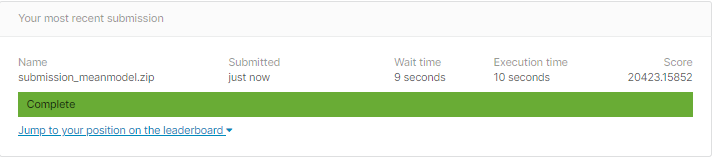

### Meadian Model

In [ ]:
mean_model = np.median(train_data['Weekly_Sales'])
wmae(train_data,train_data['Weekly_Sales'].values,np.array([mean_model]*len(train_data)))
# print(wmae)

13606.16

### Lagged Model

In [ ]:
# mean_model = np.mean(train_data['Weekly_Sales'])
wmae(train_data,train_data['Weekly_Sales'].values,create_lag_feature(train_data))
# print(wmae)

2864.31

In [ ]:
np.log10(2) == np.round(10**0.30102,2)

False

## Model Creating

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y = train_data['Weekly_Sales'].values
x = train_data.drop(['Weekly_Sales'],axis=1)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25)

In [ ]:
x_train

,Store,Dept,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Count_Holiday,Month,Year,day,Super_Bowl,Labors_Day,Thanksgiving,Christmas
413862,45,14,0,2,118221,73.88,3.881,0.00,0.00,0.00,0.00,0.00,0,6,2011,10,0,0,0,0
382726,41,13,0,3,196321,42.16,2.748,0.00,0.00,0.00,0.00,0.00,0,10,2010,29,0,0,0,0
273152,28,49,0,3,206302,54.54,4.250,11431.91,101.02,6.93,2060.55,9332.74,0,3,2012,9,0,0,0,0
37257,4,72,0,3,205863,35.92,3.103,2461.94,69.05,2938.24,52.00,4396.76,2,12,2011,23,0,0,0,0
32027,4,19,0,3,205863,36.44,3.149,2756.67,72.30,1790.15,777.65,10261.95,0,12,2011,16,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60734,7,13,0,2,70713,63.59,2.684,0.00,0.00,0.00,0.00,0.00,0,6,2010,11,0,0,0,0
17976,2,72,0,3,202307,78.69,3.452,12162.04,463.60,78.39,3610.78,10877.64,0,6,2012,8,0,0,0,0
246609,25,95,0,2,128107,71.93,3.722,21796.09,67.99,5.10,14696.25,3555.23,0,8,2012,10,0,0,0,0
42519,5,21,0,2,34875,69.17,3.594,908.91,0.00,0.00,0.00,709.95,0,10,2012,19,0,0,0,0


###Linear Regression

In [ ]:
scaling = ['Size','Temperature','Fuel_Price']

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train[scaling])
x_train[scaling] = ss.transform(x_train[scaling])
x_test[scaling] = ss.transform(x_test[scaling])

In [ ]:
test_data[scaling] = ss.transform(test_data[scaling])

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)

In [ ]:
wmae(x_test,y_test,y_pred)

14824.34

In [ ]:
y_pred_test = lr.predict(test_data)

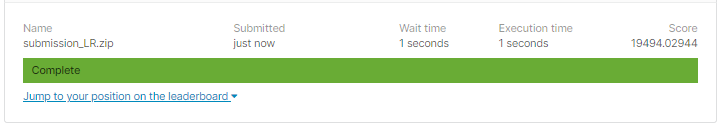

### DTRegression

In [ ]:
from sklearn.model_selection import train_test_split
y = train_data['Weekly_Sales'].values
x = train_data.drop(['Weekly_Sales'],axis=1)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25)

In [ ]:
from sklearn.tree import  DecisionTreeRegressor
from tqdm import tqdm
def DTRegression(max_depth,min_samples_leaf):
  result = []
  for depth in tqdm(max_depth):
    for sample_leaf in min_samples_leaf:
      # y_pred = []
      dt_reg = DecisionTreeRegressor(max_depth=depth,min_samples_leaf=sample_leaf)
      dt_reg.fit(x_train,y_train)
      y_pred = dt_reg.predict(x_test)

      result.append({'max_depth':depth,'min_samples_leaf':sample_leaf,'wmae':wmae(x_test,y_test,y_pred)})
  return result

In [ ]:
depth = [3,5,7,9,11,13,15]
min_leaf = [5,10,50,100,500]
DTRegression(depth,min_leaf)

100%|██████████| 7/7 [01:10<00:00, 10.06s/it]


[{'max_depth': 3, 'min_samples_leaf': 5, 'wmae': 11635.22},
 {'max_depth': 3, 'min_samples_leaf': 10, 'wmae': 11635.22},
 {'max_depth': 3, 'min_samples_leaf': 50, 'wmae': 11635.22},
 {'max_depth': 3, 'min_samples_leaf': 100, 'wmae': 11635.22},
 {'max_depth': 3, 'min_samples_leaf': 500, 'wmae': 11635.22},
 {'max_depth': 5, 'min_samples_leaf': 5, 'wmae': 9706.54},
 {'max_depth': 5, 'min_samples_leaf': 10, 'wmae': 9706.54},
 {'max_depth': 5, 'min_samples_leaf': 50, 'wmae': 9706.54},
 {'max_depth': 5, 'min_samples_leaf': 100, 'wmae': 9706.54},
 {'max_depth': 5, 'min_samples_leaf': 500, 'wmae': 9706.54},
 {'max_depth': 7, 'min_samples_leaf': 5, 'wmae': 6767.05},
 {'max_depth': 7, 'min_samples_leaf': 10, 'wmae': 6764.55},
 {'max_depth': 7, 'min_samples_leaf': 50, 'wmae': 6792.78},
 {'max_depth': 7, 'min_samples_leaf': 100, 'wmae': 6812.06},
 {'max_depth': 7, 'min_samples_leaf': 500, 'wmae': 6944.28},
 {'max_depth': 9, 'min_samples_leaf': 5, 'wmae': 5327.03},
 {'max_depth': 9, 'min_samples_le

In [ ]:
final_dt = DecisionTreeRegressor(max_depth=15,min_samples_leaf=5)
final_dt.fit(x_train,y_train)
y_pred_test = final_dt.predict(test_data)

In [ ]:
lst = pd.Series(np.abs(final_dt.feature_importances_))
lst.index = x_train.columns
lst.sort_values(ascending=False)

Dept             0.653516
Size             0.210345
Store            0.054737
Thanksgiving     0.023518
Month            0.019219
Type             0.014460
day              0.008308
Temperature      0.006490
Fuel_Price       0.002823
Christmas        0.001387
MarkDown4        0.000946
MarkDown5        0.000865
MarkDown3        0.000826
Count_Holiday    0.000799
IsHoliday        0.000664
MarkDown1        0.000513
Year             0.000278
MarkDown2        0.000196
Labors_Day       0.000073
Super_Bowl       0.000038
dtype: float64

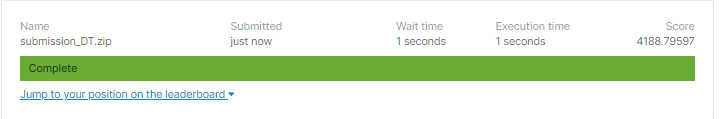

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
def randomForestRegressor_tuning(n_estimators,max_depth):
  result =[]
  for estimator in tqdm(n_estimators):
    for depth in max_depth:
      rf = RandomForestRegressor(n_estimators=estimator,max_depth=depth,n_jobs=-1)
      rf.fit(x_train,y_train)
      y_pred = rf.predict(x_test)
      result.append({'max_depth':depth,'n_estimators':estimator,'wmae':wmae(x_test,y_test,y_pred)})

  return result

In [ ]:
max_dept = [10,30,50]
n_estimaros = [50,100,200,300]
randomForestRegressor_tuning(n_estimators=n_estimaros,max_depth=max_dept)


100%|██████████| 4/4 [1:08:41<00:00, 1030.38s/it]


[{'max_depth': 10, 'n_estimators': 50, 'wmae': 4247.68},
 {'max_depth': 30, 'n_estimators': 50, 'wmae': 1557.97},
 {'max_depth': 50, 'n_estimators': 50, 'wmae': 1561.99},
 {'max_depth': 10, 'n_estimators': 100, 'wmae': 4250.39},
 {'max_depth': 30, 'n_estimators': 100, 'wmae': 1554.08},
 {'max_depth': 50, 'n_estimators': 100, 'wmae': 1549.81},
 {'max_depth': 10, 'n_estimators': 200, 'wmae': 4253.85},
 {'max_depth': 30, 'n_estimators': 200, 'wmae': 1547.8},
 {'max_depth': 50, 'n_estimators': 200, 'wmae': 1547.52},
 {'max_depth': 10, 'n_estimators': 300, 'wmae': 4254.21},
 {'max_depth': 30, 'n_estimators': 300, 'wmae': 1547.41},
 {'max_depth': 50, 'n_estimators': 300, 'wmae': 1545.16}]

#### model with min features

In [ ]:
x_train = x_train.drop(['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3','MarkDown4', 'MarkDown5', 'Super_Bowl','Labors_Day', 'Thanksgiving', 'Christmas', 'Count_Holiday'],axis=1)
test_data = test_data.drop(['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3','MarkDown4', 'MarkDown5', 'Super_Bowl','Labors_Day', 'Thanksgiving', 'Christmas', 'Count_Holiday'],axis=1)

final_rf = RandomForestRegressor(max_depth=50,n_estimators=300)
final_rf.fit(x_train,y_train)
# y_pred_test = final_rf.predict(test_data)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
# x_test = x_test.drop(['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3','MarkDown4', 'MarkDown5', 'Super_Bowl','Labors_Day', 'Thanksgiving', 'Christmas', 'Count_Holiday'],axis=1)
y_pred = final_rf.predict(x_test)
wmae(x_test,y_pred,y_test)

1453.4

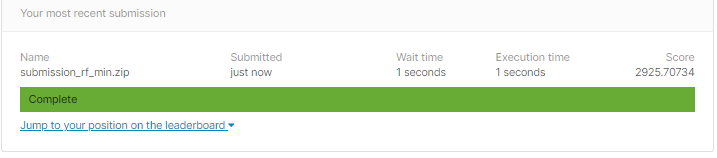

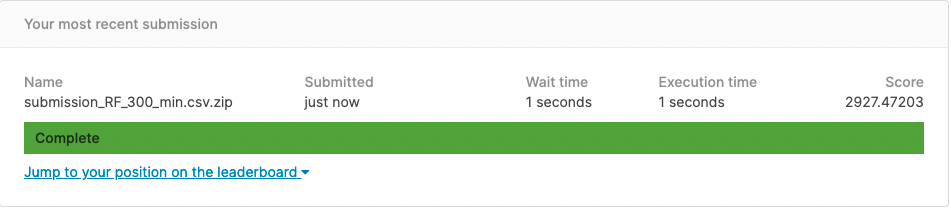

#### Rf normal

In [ ]:
final_rf1 = RandomForestRegressor(max_depth=50,n_estimators=300,n_jobs=-1)
final_rf1.fit(x_train,y_train)
y_pred = final_rf1.predict(x_test)

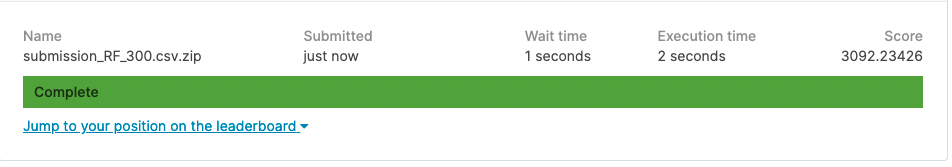

In [ ]:
y_pred_test = final_rf1.predict(test_data)

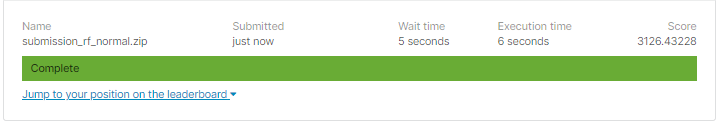

### XGB

In [ ]:
from xgboost import XGBRegressor 
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
def xgboost_tuning(n_estimators,max_depth):
  result =[]
  for estimator in tqdm(n_estimators):
    for depth in max_depth:
      xgb = XGBRegressor(n_estimators=estimator,max_depth=depth,n_jobs=-1)
      xgb.fit(x_train,y_train)
      y_pred = xgb.predict(x_test)
      result.append({'max_depth':depth,'n_estimators':estimator,'wmae':wmae(x_test,y_test,y_pred)})

  return result


In [ ]:
n_estimator_ = [50,100,500,750,1000]
depth = [5,10,15,20]
xgboost_tuning(n_estimator_,depth)

  0%|          | 0/5 [00:00<?, ?it/s]

[10:53:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:54:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:54:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:56:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 20%|██        | 1/5 [04:06<16:25, 246.37s/it]

[10:58:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:58:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:02:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 40%|████      | 2/5 [12:05<15:48, 316.18s/it]

[11:06:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:08:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 60%|██████    | 3/5 [46:40<28:07, 843.72s/it]

[11:40:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:44:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:53:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:08:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 80%|████████  | 4/5 [1:37:34<25:06, 1506.94s/it]

[12:31:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:36:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:48:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 5/5 [2:45:12<00:00, 1982.55s/it]


[{'max_depth': 5, 'n_estimators': 50, 'wmae': 6247.75},
 {'max_depth': 10, 'n_estimators': 50, 'wmae': 2591.9},
 {'max_depth': 15, 'n_estimators': 50, 'wmae': 1524.24},
 {'max_depth': 20, 'n_estimators': 50, 'wmae': 1459.56},
 {'max_depth': 5, 'n_estimators': 100, 'wmae': 4970.53},
 {'max_depth': 10, 'n_estimators': 100, 'wmae': 2103.29},
 {'max_depth': 15, 'n_estimators': 100, 'wmae': 1405.5},
 {'max_depth': 20, 'n_estimators': 100, 'wmae': 1416.29},
 {'max_depth': 5, 'n_estimators': 500, 'wmae': 3447.93},
 {'max_depth': 10, 'n_estimators': 500, 'wmae': 1587.75},
 {'max_depth': 15, 'n_estimators': 500, 'wmae': 1364.02},
 {'max_depth': 20, 'n_estimators': 500, 'wmae': 1414.74},
 {'max_depth': 5, 'n_estimators': 750, 'wmae': 3220.16},
 {'max_depth': 10, 'n_estimators': 750, 'wmae': 1508.87},
 {'max_depth': 15, 'n_estimators': 750, 'wmae': 1362.07},
 {'max_depth': 20, 'n_estimators': 750, 'wmae': 1414.86},
 {'max_depth': 5, 'n_estimators': 1000, 'wmae': 3038.0},
 {'max_depth': 10, 'n_est

In [ ]:
x_train.columns

Index(['Store', 'Dept', 'IsHoliday', 'Type', 'Size', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'Count_Holiday', 'Month', 'Year', 'day', 'Super_Bowl',
       'Labors_Day', 'Thanksgiving', 'Christmas'],
      dtype='object')

In [ ]:
from xgboost import XGBRegressor 

#### XGB with all features

In [ ]:
xgb = XGBRegressor(n_estimators=1000,max_depth=15,n_jobs=-1)
xgb.fit(x_train,y_train)
y_pred_test = xgb.predict(test_data)

[17:58:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

#### XGB with min features

In [ ]:
x_train = x_train.drop(['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3','MarkDown4', 'MarkDown5', 'Super_Bowl','Labors_Day', 'Thanksgiving', 'Christmas', 'Count_Holiday'],axis=1)
test_data = test_data.drop(['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3','MarkDown4', 'MarkDown5', 'Super_Bowl','Labors_Day', 'Thanksgiving', 'Christmas', 'Count_Holiday'],axis=1)

In [ ]:
xgb = XGBRegressor(n_estimators=1000,max_depth=15,n_jobs=-1)
xgb.fit(x_train,y_train)
y_pred_test = xgb.predict(test_data)

[18:42:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
wmae(x_test,y_pred,y_test)

1403.95

In [ ]:
lst = pd.Series(np.abs(xgb.feature_importances_))
lst.index = x_train.columns
lst.sort_values(ascending=False)

Thanksgiving    0.382489
Size            0.206643
Dept            0.165374
Type            0.155465
Store           0.031849
Month           0.019773
IsHoliday       0.013346
day             0.006430
Labors_Day      0.004817
Year            0.003750
Temperature     0.002243
Christmas       0.002206
Super_Bowl      0.002093
MarkDown5       0.001897
Fuel_Price      0.001626
dtype: float32

In [ ]:
wmae(x_test,y_pred,y_test)

1376.87

In [ ]:
y_pred_test = xgb.predict(test_data)

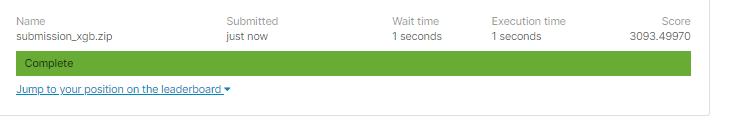

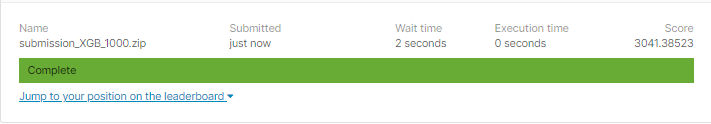

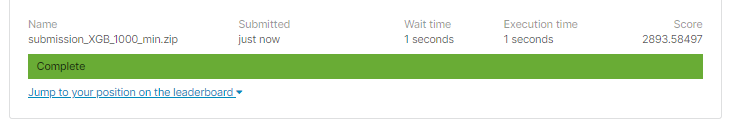

###Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from tqdm import tqdm

#### All features

In [ ]:
def adaBoostRegressorTuning(estimators,learning_rate):
  result = []
  for estimator in tqdm(estimators):
    for rate in learning_rate:
      adaboost = AdaBoostRegressor(n_estimators=estimator,learning_rate=rate)
      adaboost.fit(x_train,y_train)
      y_pred = adaboost.predict(x_test)
      result.append({'estimators':estimator,'learning_rate':rate,'wmae':wmae(x_test,y_test,y_pred)})

  return result
  

In [ ]:
estimators = [10,30,50,70,90]
learning_rate = [0.001,0.01,0.1]
adaBoostRegressorTuning(estimators,learning_rate)


100%|██████████| 5/5 [13:41<00:00, 164.26s/it]


[{'estimators': 10, 'learning_rate': 0.001, 'wmae': 11573.11},
 {'estimators': 10, 'learning_rate': 0.01, 'wmae': 11567.31},
 {'estimators': 10, 'learning_rate': 0.1, 'wmae': 11703.16},
 {'estimators': 30, 'learning_rate': 0.001, 'wmae': 11570.09},
 {'estimators': 30, 'learning_rate': 0.01, 'wmae': 11653.5},
 {'estimators': 30, 'learning_rate': 0.1, 'wmae': 12834.39},
 {'estimators': 50, 'learning_rate': 0.001, 'wmae': 11551.82},
 {'estimators': 50, 'learning_rate': 0.01, 'wmae': 11604.51},
 {'estimators': 50, 'learning_rate': 0.1, 'wmae': 15081.41},
 {'estimators': 70, 'learning_rate': 0.001, 'wmae': 11560.26},
 {'estimators': 70, 'learning_rate': 0.01, 'wmae': 11779.28},
 {'estimators': 70, 'learning_rate': 0.1, 'wmae': 16967.72},
 {'estimators': 90, 'learning_rate': 0.001, 'wmae': 11555.28},
 {'estimators': 90, 'learning_rate': 0.01, 'wmae': 11885.09},
 {'estimators': 90, 'learning_rate': 0.1, 'wmae': 17598.65}]

In [ ]:
adaboost = AdaBoostRegressor(n_estimators=estimator,learning_rate=rate)
adaboost.fit(x_train,y_train)
y_pred_test = adaboost.predict(test_data)

####Ada bosst min features

In [ ]:
x_train = x_train.drop(['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3','MarkDown4', 'MarkDown5', 'Super_Bowl','Labors_Day', 'Thanksgiving', 'Christmas', 'Count_Holiday'],axis=1)
test_data = test_data.drop(['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3','MarkDown4', 'MarkDown5', 'Super_Bowl','Labors_Day', 'Thanksgiving', 'Christmas', 'Count_Holiday'],axis=1)

In [ ]:
x_test = x_test.drop(['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3','MarkDown4', 'MarkDown5', 'Super_Bowl','Labors_Day', 'Thanksgiving', 'Christmas', 'Count_Holiday'],axis=1)

In [ ]:
adaboost = AdaBoostRegressor(n_estimators=70,learning_rate=0.001)
adaboost.fit(x_train,y_train)
y_pred = adaboost.predict(x_test)
# y_pred_test = adaboost.predict(test_data)

In [ ]:
wmae(x_test,y_pred,y_test)

11575.72

### Custom Ensemble model

In [ ]:
from xgboost import XGBRegressor 
from sklearn.ensemble import RandomForestRegressor

#### All features

In [ ]:
def create_custom_ensemble_model(xgb,final_rf,x_test):
  y_pred_xgb = xgb.predict(x_test)
  y_pred_rf = final_rf.predict(x_test)
  return (np.array(y_pred_xgb) + np.array(y_pred_rf))/2

In [ ]:
def get_ensemble_models():
  xgb = XGBRegressor(n_estimators=1000,max_depth=15,n_jobs=-1)
  xgb.fit(x_train,y_train)
  print("xgb done")
  final_rf = RandomForestRegressor(max_depth=50,n_estimators=300,n_jobs=-1)
  final_rf.fit(x_train,y_train)
  return xgb,final_rf 


In [ ]:
xgb,rf = get_ensemble_models()

[17:24:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgb done


In [ ]:
y_pred = create_custom_ensemble_model(xgb,rf,x_test)

In [ ]:
wmae(x_test,y_pred,y_test)

1380.05

In [ ]:
y_pred_test = create_custom_ensemble_model(xgb,rf,test_data)

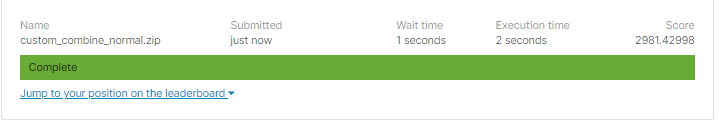

#### Min features

In [ ]:
x_train = x_train.drop(['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3','MarkDown4', 'MarkDown5', 'Super_Bowl','Labors_Day', 'Thanksgiving', 'Christmas', 'Count_Holiday'],axis=1)
test_data = test_data.drop(['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3','MarkDown4', 'MarkDown5', 'Super_Bowl','Labors_Day', 'Thanksgiving', 'Christmas', 'Count_Holiday'],axis=1)

In [ ]:
def create_custom_ensemble_model(xgb,final_rf,x_test):
  y_pred_xgb = xgb.predict(x_test)
  y_pred_rf = final_rf.predict(x_test)
  return (np.array(y_pred_xgb) + np.array(y_pred_rf))/2

In [ ]:
def get_ensemble_models():
  xgb = XGBRegressor(n_estimators=1000,max_depth=15,n_jobs=-1)
  xgb.fit(x_train,y_train)
  print("xgb done")
  final_rf = RandomForestRegressor(max_depth=50,n_estimators=300,n_jobs=-1)
  final_rf.fit(x_train,y_train)
  return xgb,final_rf 


In [ ]:
xgb,rf = get_ensemble_models()

[18:37:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgb done


In [ ]:
x_test = x_test.drop(['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3','MarkDown4', 'MarkDown5', 'Super_Bowl','Labors_Day', 'Thanksgiving', 'Christmas', 'Count_Holiday'],axis=1)
y_pred = create_custom_ensemble_model(xgb,rf,x_test)


In [ ]:
wmae(x_test,y_pred,y_test)

1329.62

In [ ]:
y_pred_test = create_custom_ensemble_model(xgb,rf,test_data)

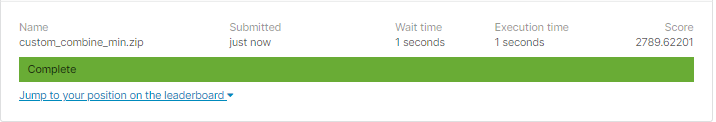

### Submission

In [ ]:
!unzip sampleSubmission.csv.zip

Archive:  sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    


In [ ]:
submission = pd.read_csv('sampleSubmission.csv')
submission['Weekly_Sales'] = y_pred_test
submission.to_csv('custom_combine_min.csv',index=False)

### Conclusion

In [ ]:
from prettytable import PrettyTable
pt = PrettyTable()
pt.field_names = ['Model Name','WMAE on test','WMAE on kaggle']
pt.add_row(['Linear Regression',14824.34,19494.02])
pt.add_row(['Decision Tree',2456.51,4188])
pt.add_row(['Random Forest',1545.16,3092.32])
pt.add_row(['Random Forest Min features',1453.4,2927.42])
pt.add_row(['XG boost',1361.84,3041.38])
pt.add_row(['XG boost Min',1403.95,2893.58])
pt.add_row(['Adaboost',11575.72,""])
pt.add_row(['Custom ensemble all features',1380.05,2981.42])
pt.add_row(['Custom ensemble min ',1329.62,2789.62])

print(pt)

+------------------------------+--------------+----------------+
|          Model Name          | WMAE on test | WMAE on kaggle |
+------------------------------+--------------+----------------+
|      Linear Regression       |   14824.34   |    19494.02    |
|        Decision Tree         |   2456.51    |      4188      |
|        Random Forest         |   2456.51    |      4188      |
|  Random Forest Min features  |   2456.51    |      4188      |
|           XG boost           |   1361.84    |    3041.38     |
|         XG boost Min         |   1403.95    |    2893.58     |
|           Adaboost           |   11575.72   |                |
| Custom ensemble all features |   1380.05    |    2981.42     |
|     Custom ensemble min      |   1329.62    |    2789.62     |
+------------------------------+--------------+----------------+
